In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
# Load data
anger_train = pd.read_csv("anger_train.csv")
fear_train = pd.read_csv("fear_train.csv")
joy_train = pd.read_csv("joy_train.csv")
sad_train = pd.read_csv("sadness_train.csv")

In [3]:
# Combine datasets
frames = [anger_train, fear_train, joy_train, sad_train]
data_training = pd.concat(frames)
data_training.reset_index(inplace=True)

In [4]:
data_training.head()

,index,id,text,label,intensity
0,0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
data_training.tail()

,index,id,text,label,intensity
3608,781,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104
3609,782,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104
3610,783,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088
3611,784,40784,@BluesfestByron second artist announcement loo...,sadness,0.083
3612,785,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083


In [6]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+|https?://[A-Za-z0-9./]+|[^a-zA-Z]', ' ', text)
    return text.lower()


In [7]:
# Apply text cleaning
data_training['clean_text'] = data_training['text'].apply(clean_text)


In [8]:
data_training.tail()

,index,id,text,label,intensity,clean_text
3608,781,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104,thank you so much just home stunned but s...
3609,782,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104,just put the winter duvet on
3610,783,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088,that s so pretty i love the sky in the ba...
3611,784,40784,@BluesfestByron second artist announcement loo...,sadness,0.083,second artist announcement looking good blu...
3612,785,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083,i can literally eat creamy pesto pasta topped ...


In [9]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data_training['clean_text'])
X = tokenizer.texts_to_sequences(data_training['clean_text'])
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

In [10]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, data_training['intensity'], test_size=0.2, random_state=42)

In [12]:
# Define a different CNN model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [13]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr * 0.9
    else:
        return lr
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

In [15]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint, learning_rate_scheduler])

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0362 - mae: 0.1554 - val_loss: 0.0353 - val_mae: 0.1527 - learning_rate: 9.0000e-04
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0362 - mae: 0.1556 - val_loss: 0.0344 - val_mae: 0.1505 - learning_rate: 9.0000e-04
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0246 - mae: 0.1238 - val_loss: 0.0326 - val_mae: 0.1454 - learning_rate: 9.0000e-04
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0141 - mae: 0.0915 - val_loss: 0.0331 - val_mae: 0.1459 - learning_rate: 9.0000e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0097 - mae: 0.0754 - val_loss: 0.0345 - val_mae: 0.1491 - learning_rate: 9.0000e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - mae: 0.0610 - val_loss: 0.0353 - val_mae: 0.1502 - learning_rate: 8.1000e-04


In [16]:
# Load best model
model.load_weights('best_model.keras')

In [17]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 50)             │         409,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 64)              │           9,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 47, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2944)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         188,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897,841 (7.24 MB)

 Trainable params: 632,613 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,265,228 (4.83 MB)

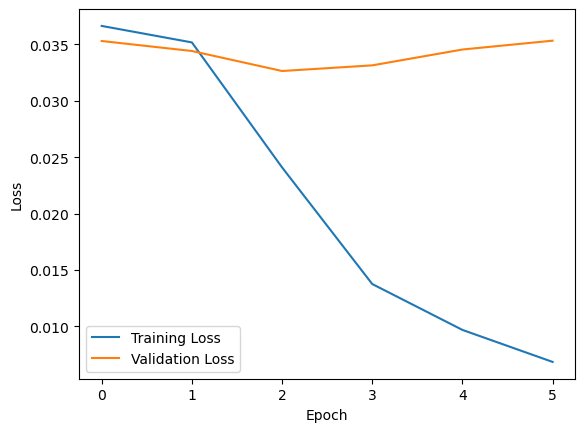

In [18]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Load test data
anger_test = pd.read_csv("anger_test.csv")
fear_test = pd.read_csv("fear_test.csv")
joy_test = pd.read_csv("joy_test.csv")
sad_test = pd.read_csv("sadness_test.csv")

In [20]:
# Clean and tokenize test data
anger_test['clean_text'] = anger_test['text'].apply(clean_text)
X_anger_test = tokenizer.texts_to_sequences(anger_test['clean_text'])
X_anger_test = tf.keras.preprocessing.sequence.pad_sequences(X_anger_test, maxlen=100)

fear_test['clean_text'] = fear_test['text'].apply(clean_text)
X_fear_test = tokenizer.texts_to_sequences(fear_test['clean_text'])
X_fear_test = tf.keras.preprocessing.sequence.pad_sequences(X_fear_test, maxlen=100)

joy_test['clean_text'] = joy_test['text'].apply(clean_text)
X_joy_test = tokenizer.texts_to_sequences(joy_test['clean_text'])
X_joy_test = tf.keras.preprocessing.sequence.pad_sequences(X_joy_test, maxlen=100)

sad_test['clean_text'] = sad_test['text'].apply(clean_text)
X_sad_test = tokenizer.texts_to_sequences(sad_test['clean_text'])
X_sad_test = tf.keras.preprocessing.sequence.pad_sequences(X_sad_test, maxlen=100)


In [21]:
# Make predictions
Y_anger_predicted = model.predict(X_anger_test)
Y_fear_predicted = model.predict(X_fear_test)
Y_joy_predicted = model.predict(X_joy_test)
Y_sad_predicted = model.predict(X_sad_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [24]:
# Calculate Mean Absolute Error (MAE) for each emotion category
anger_mae = mean_absolute_error(anger_test['intensity'], Y_anger_predicted[:, 0])
fear_mae = mean_absolute_error(fear_test['intensity'], Y_fear_predicted[:, 0])
joy_mae = mean_absolute_error(joy_test['intensity'], Y_joy_predicted[:, 0])
sad_mae = mean_absolute_error(sad_test['intensity'], Y_sad_predicted[:, 0])

# Print MAE for each emotion category
print("Mean Absolute Error for Anger:", anger_mae)
print("Mean Absolute Error for Fear:", fear_mae)
print("Mean Absolute Error for Joy:", joy_mae)
print("Mean Absolute Error for Sadness:", sad_mae)

Mean Absolute Error for Anger: 0.13863771670680297
Mean Absolute Error for Fear: 0.15557384373818212
Mean Absolute Error for Joy: 0.17643857258441403
Mean Absolute Error for Sadness: 0.15866560733477747


In [22]:
# Evaluate the model
anger_pearson = pearsonr(anger_test['intensity'], Y_anger_predicted[:, 0])[0]
fear_pearson = pearsonr(fear_test['intensity'], Y_fear_predicted[:, 0])[0]
joy_pearson = pearsonr(joy_test['intensity'], Y_joy_predicted[:, 0])[0]
sad_pearson = pearsonr(sad_test['intensity'], Y_sad_predicted[:, 0])[0]

In [23]:
print("Pearson Correlation for Anger:", anger_pearson)
print("Pearson Correlation for Fear:", fear_pearson)
print("Pearson Correlation for Joy:", joy_pearson)
print("Pearson Correlation for Sadness:", sad_pearson)

Pearson Correlation for Anger: 0.24608236331612193
Pearson Correlation for Fear: 0.3271942614919348
Pearson Correlation for Joy: 0.19278886900593584
Pearson Correlation for Sadness: 0.32923789296671463


In [25]:
# Spearman correlation
anger_spearman = spearmanr(anger_test['intensity'], Y_anger_predicted[:, 0])[0]
fear_spearman = spearmanr(fear_test['intensity'], Y_fear_predicted[:, 0])[0]
joy_spearman = spearmanr(joy_test['intensity'], Y_joy_predicted[:, 0])[0]
sad_spearman = spearmanr(sad_test['intensity'], Y_sad_predicted[:, 0])[0]

print("Spearman Correlation for Anger:", anger_spearman)
print("Spearman Correlation for Fear:", fear_spearman)
print("Spearman Correlation for Joy:", joy_spearman)
print("Spearman Correlation for Sadness:", sad_spearman)


Spearman Correlation for Anger: 0.22455208646625888
Spearman Correlation for Fear: 0.3168272297477534
Spearman Correlation for Joy: 0.1941883563036288
Spearman Correlation for Sadness: 0.31672479580832846


In [26]:
# Correlation scores on high intensity subset
high_intensity_subset = pd.concat([anger_test[anger_test['intensity'] >= 0.5],
                                   fear_test[fear_test['intensity'] >= 0.5],
                                   joy_test[joy_test['intensity'] >= 0.5],
                                   sad_test[sad_test['intensity'] >= 0.5]])

Y_high_intensity_predicted = np.concatenate([Y_anger_predicted[anger_test['intensity'] >= 0.5],
                                             Y_fear_predicted[fear_test['intensity'] >= 0.5],
                                             Y_joy_predicted[joy_test['intensity'] >= 0.5],
                                             Y_sad_predicted[sad_test['intensity'] >= 0.5]])

high_intensity_pearson = pearsonr(high_intensity_subset['intensity'], Y_high_intensity_predicted[:, 0])[0]
high_intensity_spearman = spearmanr(high_intensity_subset['intensity'], Y_high_intensity_predicted[:, 0])[0]

In [27]:
print("Pearson Correlation on High Intensity Subset:", high_intensity_pearson)
print("Spearman Correlation on High Intensity Subset:", high_intensity_spearman)

Pearson Correlation on High Intensity Subset: 0.24317050105375643
Spearman Correlation on High Intensity Subset: 0.23101876983135647
